In [4]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm

In [5]:
file = "RH50_test_f0_all.dat"
ds = h5py.File(file, "r")
print(ds.keys())

print(np.nanmax(np.asarray(ds["grid_u_c_xyzt"])))


<KeysViewHDF5 ['_types', 'grid_geopots_xyzt', 'grid_lnp_full_xyzt', 'grid_lnp_half_xyzt', 'grid_lnps_xyzt', 'grid_p_full_xyzt', 'grid_p_half_xyzt', 'grid_ps_xyzt', 'grid_t_c_xyzt', 'grid_t_eq_xyzt', 'grid_tracers_c_xyz1t', 'grid_tracers_diff_xyz1t', 'grid_tracers_n_xyz1t', 'grid_tracers_p_xyz1t', 'grid_u_c_xyzt', 'grid_v_c_xyzt', 'grid_w_full_xyzt', 'grid_Δp_xyzt', 'spe_div_c_xyzt', 'spe_lnps_c_xyzt', 'spe_lnps_p_xyzt', 'spe_vor_c_xyzt']>
90.74618921649396


In [6]:
lat_0 = np.array([-1.5335125830545813, -1.485214577958351, -1.4366313478480872, -1.3879836743385505, -1.3393115571950114, -1.2906276131055214, -1.241937060919817, -1.1932424462905298, -1.144545157917862, -1.0958460174998903, -1.0471455422784188, -0.9984440741325684, -0.9497418481523823, -0.9010390313853844, -0.8523357458658898, -0.8036320828934408, -0.7549281122089407, -0.7062238880767123, -0.6575194534257702, -0.6088148427373913, -0.5601100841016827, -0.5114052007106801, -0.4627002119616472, -0.41399513428591594, -0.3652899817814796, -0.31658476670341296, -0.26787949985019416, -0.21917419087322776, -0.17046884852950536, -0.12176348089226514, -0.07305809553098731, -0.024352699669631092, 0.024352699669631092, 0.07305809553098731, 0.12176348089226514, 0.17046884852950536, 0.21917419087322776, 0.26787949985019416, 0.31658476670341296, 0.3652899817814796, 0.41399513428591594, 0.4627002119616472, 0.5114052007106801, 0.5601100841016827, 0.6088148427373913, 0.6575194534257702, 0.7062238880767123, 0.7549281122089407, 0.8036320828934408, 0.8523357458658898, 0.9010390313853844, 0.9497418481523823, 0.9984440741325684, 1.0471455422784188, 1.0958460174998903, 1.144545157917862, 1.1932424462905298, 1.241937060919817, 1.2906276131055214, 1.3393115571950114, 1.3879836743385505, 1.4366313478480872, 1.485214577958351, 1.5335125830545813]) * 180 / np.pi
lat = np.broadcast_to(lat_0, (20, 128, 64))

In [7]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        
    def getVar(self, var):
        return np.asarray(self.ds[var])

In [8]:
file_50 = "RH50_test_f0_all2.dat"
file_80 = "RH80_test_f0_all2.dat"

dycore_50  = Dycore(file_50)
dycore_80  = Dycore(file_80)

u_50 = dycore_50.getVar("grid_u_c_xyzt")
u_80 = dycore_80.getVar("grid_u_c_xyzt")

print(np.nanmax(u_50 - u_80))

0.0


In [26]:
def plot_EMF_80(pr):
    file = f"RH{pr}_test_f0_all.dat"
    print(pr)

    dycore = Dycore(file)
    qv = dycore.getVar("grid_tracers_p_xyz1t")
    u = dycore.getVar("grid_u_c_xyzt")
    v = dycore.getVar("grid_v_c_xyzt")
    t = dycore.getVar("grid_t_c_xyzt")
    # p = dycore.getVar("grid_p_full_xyzt")
    # sigma = dycore.getVar("grid_p_full_xyzt") / dycore.getVar("grid_ps_xyzt")

    v_prime = np.rollaxis((np.rollaxis(v, 3, 0) - np.nanmean(v, axis=3)), 0, 4)
    u_prime = np.rollaxis((np.rollaxis(u, 3, 0) - np.nanmean(u, axis=3)), 0, 4)
    t_prime = np.rollaxis((np.rollaxis(t, 3, 0) - np.nanmean(t, axis=3)), 0, 4)
    qv_prime = np.rollaxis((np.rollaxis(qv, 3, 0) - np.nanmean(qv, axis=3)), 0, 4)

    tmp = np.nanmean(u[:,:,32:,:], axis=(0, 3))
    jet_k, _ = np.unravel_index(tmp.argmax(), tmp.shape)
    b = t_prime / np.nanmean(t) * 9.81

    eddy_flux_momentum = np.nanmean(u_prime * v_prime, axis=(0, 3))
    
    eddy_flux_q = np.nanmean(qv_prime * v_prime, axis=(0, 3))

    eddy_flux_heat = np.nanmean(b * v_prime, axis=(0, 1, 3))
    
    eddy_flux_kinetic = 0.5 * np.nanmean((u_prime**2 + v_prime**2)**0.5, axis=(0, 3))
    

    # return eddy_flux_momentum[jet_k], eddy_flux_q[19], eddy_flux_heat
    return eddy_flux_momentum[jet_k], eddy_flux_q[19], eddy_flux_heat, eddy_flux_kinetic[jet_k]

In [27]:
leap = 10
to = 90
nProc = 2
# with Pool(nProc) as p:
#     results = [p.apply_async(plot_EMF_80, (t, )) for t in range(0, to, leap)]
#     final_80 = [result.get() for result in results]
EMF_80   = np.zeros((6,32))
EQF_80   = np.zeros((6,32))
EHF_80   = np.zeros((6,32))
EKF_80   = np.zeros((6,32))

a = 0
for t in (50,80):#range(0, to, leap):
    EMF_results, EQF_results, EHF_results, EKF_results = plot_EMF_80(t)    
    
    print(t,a)
    # for result in range(32):
    #     print(result.shape)
    #     print(result)
    EMF_80[a,:] = EMF_results[32:]
    EQF_80[a,:] = EQF_results[32:]
    EHF_80[a,:] = EHF_results[32:]
    EKF_80[a,:] = EKF_results[32:]
    a += 1
    
print(EMF_80.shape)
print(EMF_80)

50
50 0
80
80 1
(6, 32)
[[-0.27990928 -0.51680213 -0.64983539 -0.61333534 -0.66044969 -0.75726246
  -0.7238742  -0.70302232 -0.80127659 -0.79812087 -0.79790901 -0.80878397
  -0.83229891 -0.72370788 -0.65559021 -0.64922031 -0.61157221 -0.40345974
  -0.26001011 -0.32221981 -0.66304103 -0.83105862 -1.01728182 -0.91206027
  -0.83244447 -0.69088793 -0.64557674 -0.25620955 -0.13875708 -0.23323182
   0.18323777  0.07948106]
 [-0.27990928 -0.51680213 -0.64983539 -0.61333534 -0.66044969 -0.75726246
  -0.7238742  -0.70302232 -0.80127659 -0.79812087 -0.79790901 -0.80878397
  -0.83229891 -0.72370788 -0.65559021 -0.64922031 -0.61157221 -0.40345974
  -0.26001011 -0.32221981 -0.66304103 -0.83105862 -1.01728182 -0.91206027
  -0.83244447 -0.69088793 -0.64557674 -0.25620955 -0.13875708 -0.23323182
   0.18323777  0.07948106]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         

50 0
80 1


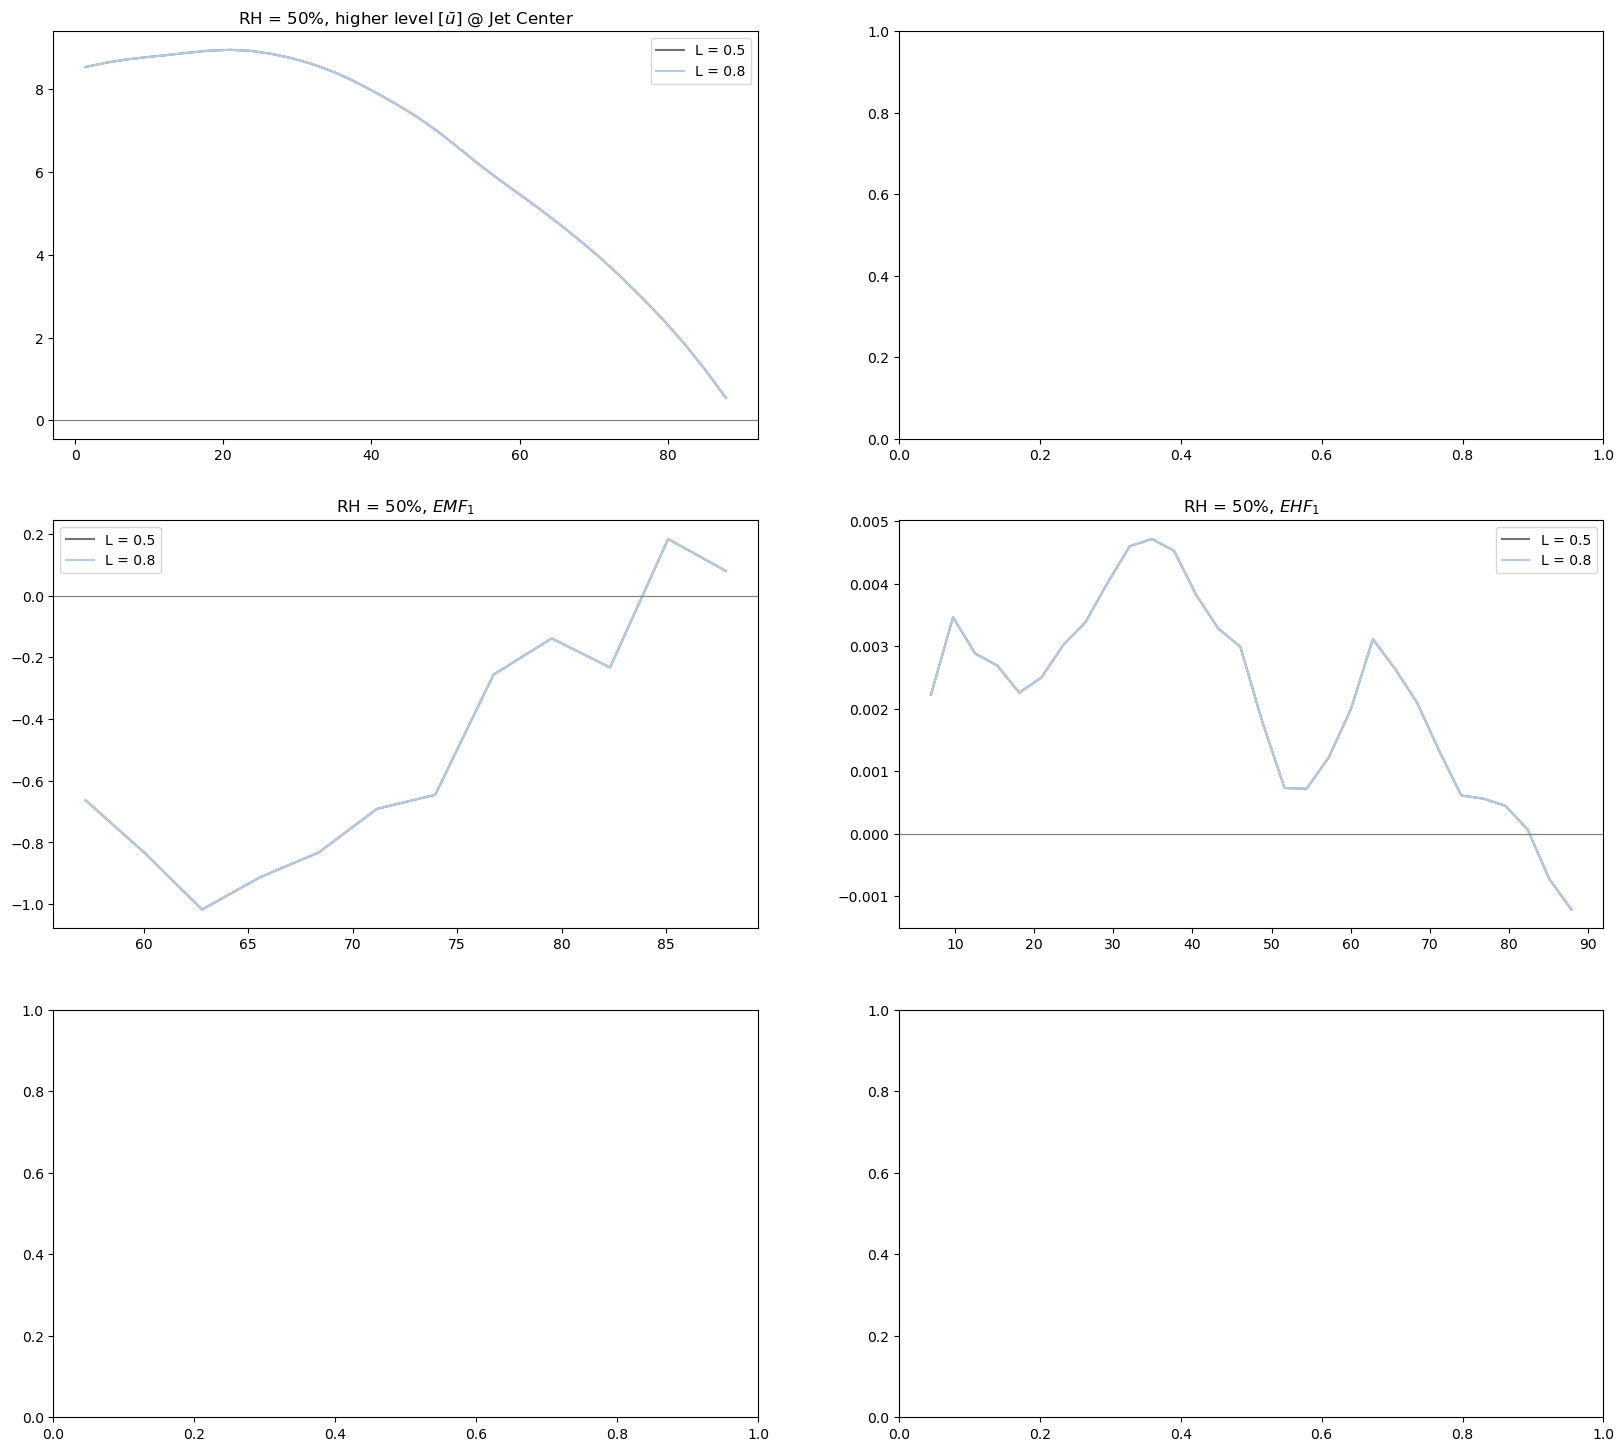

In [24]:
import matplotlib.colors as colors
import matplotlib as mpl

fig, ax = plt.subplots(3, 2, figsize=(20, 18))
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
a   = 0
for pr in (50,80):#range(0, 20, 10):
    print(pr,a)
    # file  = f"HS_front_RH80_PR{pr}_PRRELAX86400_all.dat" # ./outputs/withprecip/
    # file  = f"HS_front_RH50_PR{pr}_PRRELAX86400_day0_500_all.dat" # ./outputs/withprecip/
    
    file = f"RH{pr}_test_f0_all.dat"
    
    dycore = Dycore(file)
    qv = dycore.getVar("grid_tracers_p_xyz1t")
    u = dycore.getVar("grid_u_c_xyzt")
    v = dycore.getVar("grid_v_c_xyzt")
    qv_diff = dycore.getVar("grid_tracers_diff_xyz1t")
    # print(qv_diff.shape)
    qv_diff_sum = np.nansum(qv_diff, axis=(0,1,3))[32:]

    tmp = np.nanmean(u[:,:,32:,:], axis=(0, 3))
    k, i = np.unravel_index(tmp.argmax(), tmp.shape)

    u_jet = u[:,k,32:,:]
    u_jet_zonal_time_mean = np.nanmean(u_jet, axis=(0, 2))
    u_max_idx = np.argmax(u_jet_zonal_time_mean)
    if pr == 0:
        control = np.nanmax(u_jet_zonal_time_mean[u_max_idx-10:u_max_idx+25+1])
    ax[0,0].plot(lat_0[32:], u_jet_zonal_time_mean , label=f"L = {pr/100}", color=colors[int(a)])
    ax[0,0].set_title(r"RH = 50%, higher level [$\bar{u}$] @ Jet Center")
    # ax[0,0].set_ylim(np.min(u_jet_zonal_time_mean[u_max_idx-10:u_max_idx+25+1])-2, np.max(u_jet_zonal_time_mean[u_max_idx-10:u_max_idx+25+1])+2)
    ax[0,0].axhline(y=0, color='gray', lw=0.8)
    # ax[0,0].set_xticks(np.arange(0,90,10))
    ax[0,0].legend()
    if pr == 0:
        ax[0,0].axvline(x=lat_0[32:][u_max_idx], color='gray', lw=0.8)
    # ax[0,0].set_ylim([-0.05,1.6])
    

    EMF_max_idx = np.argmax(EMF_80[int(a)])
    ax[1,0].set_title(r"RH = 50%, $EMF_{1}$")
    ax[1,0].plot(lat_0[32:][EMF_max_idx-10:EMF_max_idx+25+1], EMF_80[int(a), EMF_max_idx-10:EMF_max_idx+25+1]  , label=f"L = {pr/100}", lw='1.5', color=colors[int(a)])
    ax[1,0].axhline(y=0, color='gray', lw=0.8)
    if pr == 0:
        ax[1,0].axvline(x=lat_0[32:][EMF_max_idx], color='gray', lw=0.95)
    ax[1,0].legend()

    EHF_max_idx = np.argmax(EHF_80[int(a)])
    ax[1,1].set_title(r"RH = 50%, $EHF_{1}$")
    ax[1,1].plot(lat_0[32:][EHF_max_idx-10:EHF_max_idx+25+1], EHF_80[int(a)][EHF_max_idx-10:EHF_max_idx+25+1]  , label=f"L = {pr/100}", lw='1.5', color=colors[int(a)])
    ax[1,1].axhline(y=0, color='gray', lw=0.8)
    if pr == 0:
        ax[1,1].axvline(x=lat_0[32:][EHF_max_idx], color='gray', lw=0.95)
    ax[1,1].legend()
    
#     EKF_max_idx = np.argmax(EKF_80[int(pr/10)])
#     ax[2,0].set_title(r"RH = 50%, $EKF_{1}$")
#     ax[2,0].plot(lat_0[32:], EKF_80[int(pr/10)]  , label=f"L = {pr/100}", lw='1.5', color=colors[int(pr/10)-3])
#     ax[2,0].axhline(y=0, color='gray', lw=0.8)
#     if pr == 0:
#         ax[2,0].axvline(x=lat_0[32:][EKF_max_idx], color='gray', lw=0.95)
#     ax[2,0].legend()
    
#     # P_max_idx = np.argmax(qv_diff_sum)
#     ax[2,1].plot(lat_0[32:], qv_diff_sum, label=f"L = {pr/100}", color=colors[int(pr/10)])
#     ax[2,1].set_title(r"RH = 50%, Precipitation")
#     # ax[1,1].set_ylim(np.min(qv_diff_sum[u_max_idx-10:u_max_idx+25+1])-0.1, np.max(qv_diff_sum[u_max_idx-10:u_max_idx+25+1])+0.1)
#     ax[2,1].set_ylim(np.min(qv_diff_sum)-30, np.max(qv_diff_sum)+300)
#     ax[2,1].legend()
    
#     # lower level
#     k = 14
#     u_jet = u[:,k,32:,:]
#     u_jet_zonal_time_mean = np.nanmean(u_jet, axis=(0, 2))
#     u_max_idx = np.argmax(u_jet_zonal_time_mean)
#     if pr == 0:
#         ax[0,1].axvline(x=lat_0[32:][u_max_idx], color='gray', lw=0.8)
#     ax[0,1].plot(lat_0[32:][u_max_idx-10:u_max_idx+25+1], u_jet_zonal_time_mean[u_max_idx-10:u_max_idx+25+1] / control, label=f"L = {pr/100}", color=colors[int(pr/10)])
#     ax[0,1].set_title(r"RH = 50%, lower level [$\bar{u}$] @ Jet Center")
#     ax[0,1].set_ylim([-0.3, 0.8])
#     ax[0,1].legend()
#     ax[0,1].axhline(y=0, color='gray', lw=0.8)
    a += 1
# plt.savefig("RH50_Nick_fig1_repreduce_testpr0_0716.png", dpi=300., bbox_inches='tight')
plt.show()